In [1]:
import os

# Why Torch? You'll find the answer in the .md files! 
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
from models.hyperparameters import Hyperparameters
import json

#Hyperparameters redefinition for model.
# todo utils for auto loading and saving
try:
    hp = Hyperparameters(**json.load(open('hyperparameters.json')))
except FileNotFoundError:
    # Create new configuration parameters
    hp = Hyperparameters()
    with open("hyperparameters.json", "w") as outfile:
        outfile.write(hp.toJSON())

In [4]:
hp.version

'1.0'

## Let's start simple
As theoretical evidence goes it is possible to aproximate any function
(see better references) by a simple NN. Unfortunally this is unfeasable
as the number of neurons should be a O(2e(d/3)) (check). 

Let's try to build a DNN (more than one layer) in order to achieve a good aproximation.

## HyperParameter: Image Size
What size should the image be? For sake of simplicity we want to consider all images to have the same size.

The more we reduce the size of an image the less information we contain as in most cases there will be a loss of information.
This loss of information while unavoidable can be actually desired as we can force the network to better generalize the features of the image.


### Memory Limits
My machine has an RTX3070Ti that only has 8GiB of VRAM and this has to be taken into account. Images can be very memory demaning as pointed out:
> It really depends on the size of your network and your GPU. You need to fit reasonably sized batch (16-64 images) in Gpu memory. That can easily be very big: you can compute the size of intermediate activations as 4 \* batch_size * num_feature_maps * height * width. Say you take 32 square images 112x112 with 64 feature maps. It would be 100Mb just for activations and the same amount for gradients. Take relatively big network (for example, VGG16) and you already need a few Gb.
Other aspect is the size of receptive field. If you follow current advices to prefer small filter size (3x3) and take big images, you can end up either with quite shallow network (because you can't fit a lot of layers into gpu) or with narrow network (which is ok if you know how to train it). Former network will necessarily have small effective receptive fields, therefore will approximate more local and simpler function.
So the rule of thumb is use images about 256x256 for ImageNet-scale networks and about 96x96 for something smaller and easier. I have heard that in kaggle people train on 512x512 sometimes, but you will need to compromise on something. Or just buy gpu cluster.
If you train fully convolutional networks like Faster RCNN you can take much bigger images (say 800x600) because you have batch size = 1.
> (https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network)


> https://arxiv.org/pdf/2103.09950.pdf Has interesting idea of learning the image size but I don't think it will be applied to this project.

In [4]:
import torchvision

loading_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((hp.image_size[1], hp.image_size[2])),
    # Todo: Check if i rescales to [-1,1]
    torchvision.transforms.ToTensor(),
    # lambda x: x.to(memory_format=torch.channels_last),
])

train_dataset = torchvision.datasets.ImageFolder("../../data/train", transform=loading_transforms)
validation_dataset = torchvision.datasets.ImageFolder("../../data/test/", transform=loading_transforms)


In [5]:
from keras import Model
from models.naive_dnn_gen.naive_dnn import naive_dnn, naive_dnn_augmentation, naive_dnn_pre_process

model_inputs, model_outputs = naive_dnn(hp.image_size)

augmentation_inputs, augmentation_outputs = naive_dnn_augmentation(hp.image_size)

#pre_naive_inputs, pre_naive_outputs = naive_dnn_pre_process(
#    hp.image_size,  #Input size of course
#    Model(model_inputs, model_outputs),
#    Model(augmentation_inputs, augmentation_outputs)
#)

pre_naive_model = Model(model_inputs, model_outputs)
pre_naive_model.summary(expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ naive_dnn (InputLayer)          │ (None, 3, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2900)           │   142,543,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1100)           │     3,191,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,735,901 (555.94 MB)

 Trainable params: 145,735,901 (555.94 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
network_size = pre_naive_model.count_params()
image_batch_size = hp.image_size[0] * hp.image_size[1] * hp.image_size[2] * hp.batch_size

# todo Find what it really is
optimizer_memory_impact = 3

print("Memory footprint of the model is around " + str(
    int((4 * (network_size + image_batch_size) * optimizer_memory_impact) / 1024 / 1024)) + " MB during training")


Memory footprint of the model is around 1685 MB during training


In [7]:
from torch.utils.data import DataLoader
from models.zero_one_validation_loss import zero_one_loss_binary

import keras

train_dataloader = DataLoader(dataset=train_dataset, batch_size=hp.batch_size, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=hp.batch_size, shuffle=True)

pre_naive_model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.learning_rate, momentum=0.5),
                        metrics=['accuracy', zero_one_loss_binary], loss=keras.losses.BinaryCrossentropy())

history = pre_naive_model.fit(train_dataloader, validation_data=validation_dataloader, epochs=hp.n_epochs, callbacks=[
    # To avoid keep going
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
])

pre_naive_model.save(f"compiled_model_{hp.version}.keras")

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 93s 624ms/step - accuracy: 0.5559 - loss: 1.3844 - zero_one_loss_binary: 15.6005 - val_accuracy: 0.7230 - val_loss: 0.6069 - val_zero_one_loss_binary: 15.6182
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.6747 - loss: 0.6040 - zero_one_loss_binary: 15.6583 - val_accuracy: 0.5853 - val_loss: 0.6965 - val_zero_one_loss_binary: 16.8395
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.6906 - loss: 0.5779 - zero_one_loss_binary: 15.6119 - val_accuracy: 0.7407 - val_loss: 0.5339 - val_zero_one_loss_binary: 15.6436
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 361ms/step - accuracy: 0.7416 - loss: 0.5316 - zero_one_loss_binary: 15.6272 - val_accuracy: 0.7568 - val_loss: 0.5107 - val_zero_one_loss_binary: 15.5034
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.7482 - loss: 0.5196 - zero_one_loss_binary: 15.4524 - val_accuracy: 0.7694 - val_loss: 0.5107 - val_zero_one_loss_binary: 15.7416


https://arxiv.org/abs/2305.19982#:~:text=Evaluated%20on%20transformer%2Dbased%20models,2%25%20degradation%20in%20training%20throughput.
An alternative to Adam

<Axes: >

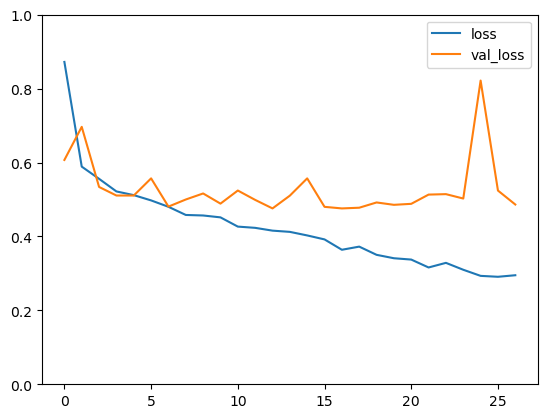

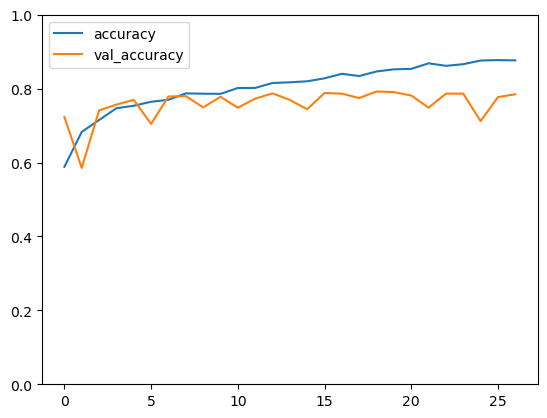

In [8]:
import pandas

metrics_df1 = pandas.DataFrame(history.history)
metrics_df1[["loss", "val_loss"]].plot(ylim=(0, 1))
metrics_df1[["accuracy", "val_accuracy"]].plot(ylim=(0, 1))

# For the 2 Hidden Layers with 2.9k / 1.1k Neurons Layers the Network is prone to Overfitting 
# as we can deduce by the fact that we had to early stop since the validation loss 
# hasn't gotten any better for a long period of time (10 Epoches)

In [9]:
metrics_df1

,accuracy,loss,zero_one_loss_binary,val_accuracy,val_loss,val_zero_one_loss_binary
0,0.588422,0.872161,15.762159,0.722973,0.606935,15.618243
1,0.682865,0.588914,15.527682,0.585304,0.696504,16.839527
2,0.714980,0.555876,15.542521,0.740709,0.533884,15.643581
3,0.746884,0.521755,15.547370,0.756757,0.510696,15.503378
4,0.753645,0.511757,15.496884,0.769426,0.510681,15.741554
5,0.764420,0.497481,15.560753,0.704392,0.557120,15.157095
6,0.769702,0.480182,15.514766,0.778716,0.480730,15.476352
7,0.787027,0.458116,15.476162,0.779561,0.499931,15.506757
8,0.786182,0.456689,15.562675,0.749155,0.516276,15.467905
9,0.785760,0.451597,15.540016,0.777872,0.488770,15.597973


In [5]:
from keras import Model
from models.naive_dnn_gen.naive_dnn import naive_dnn, naive_dnn_augmentation, naive_dnn_pre_process

model_inputs, model_outputs = naive_dnn(hp.image_size)
augmentation_inputs, augmentation_outputs = naive_dnn_augmentation(hp.image_size, random_flip=[True, True])

pre_naive_inputs, pre_naive_outputs = naive_dnn_pre_process(
    hp.image_size,  #Input size of course
    Model(model_inputs, model_outputs),
    Model(augmentation_inputs, augmentation_outputs)
)

pre_naive_model = Model(pre_naive_inputs, pre_naive_outputs)
pre_naive_model.summary(expand_nested=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ naive_dnn_pre (InputLayer)      │ (None, 3, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 3, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ naive_dnn_augmentation     │ (None, 3, 128, 128)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation            │ (None, 3, 128, 128)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip (RandomFlip)   │ (None, 3, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 1)              │   145,735,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ naive_dnn (InputLayer)     │ (None, 3, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ flatten (Flatten)          │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (None, 2900)           │   142,543,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ (None, 1100)           │     3,191,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_2 (Dense)            │ (None, 1)              │         1,101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,735,901 (555.94 MB)

 Trainable params: 145,735,901 (555.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from torch.utils.data import DataLoader
from models.zero_one_validation_loss import zero_one_loss_binary

import keras

train_dataloader = DataLoader(dataset=train_dataset, batch_size=hp.batch_size, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=hp.batch_size, shuffle=True)

pre_naive_model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.learning_rate, momentum=0.5),
                        metrics=['accuracy', zero_one_loss_binary], loss=keras.losses.BinaryCrossentropy())

history = pre_naive_model.fit(train_dataloader, validation_data=validation_dataloader, epochs=hp.n_epochs, callbacks=[
    # To avoid keep going
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
])
# Prolly too much noise
pre_naive_model.save(f"compiled_model_{hp.version}.keras")

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 391ms/step - accuracy: 0.5359 - loss: 1.0460 - zero_one_loss_binary: 15.5347 - val_accuracy: 0.5532 - val_loss: 0.6691 - val_zero_one_loss_binary: 14.8649
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 56s 380ms/step - accuracy: 0.5767 - loss: 0.6651 - zero_one_loss_binary: 15.7986 - val_accuracy: 0.5726 - val_loss: 0.6672 - val_zero_one_loss_binary: 15.7061
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5978 - loss: 0.6503 - zero_one_loss_binary: 15.5352 - val_accuracy: 0.5836 - val_loss: 0.6691 - val_zero_one_loss_binary: 16.4392
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 375ms/step - accuracy: 0.6229 - loss: 0.6447 - zero_one_loss_binary: 15.6470 - val_accuracy: 0.6503 - val_loss: 0.6381 - val_zero_one_loss_binary: 15.6402
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.6277 - loss: 0.6337 - zero_one_loss_binary: 15.7088 - val_accuracy: 0.6275 - val_loss: 0.6368 - val_zero_one_loss_binary: 15.3361
